Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import (
    TimeSeriesTransformerConfig,
    TimeSeriesTransformerForPrediction,
)
from gluonts.time_feature import (
    get_lags_for_frequency,
    time_features_from_frequency_str,
)
from gluonts.dataset.pandas import PandasDataset
from gluonts.itertools import Map
from datasets import Dataset, DatasetDict, Features, Value, Sequence
from functools import lru_cache, partial
from gluonts.dataset.field_names import FieldName

from accelerate import Accelerator
from torch.optim import AdamW
import matplotlib.dates as mdates
import sys
from pathlib import Path

# Get the parent directory
parent_dir = Path.cwd().parent.parent

# Ensure it's not already in sys.path
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model
from shared.transformer import create_train_dataloader, create_test_dataloader, transform_start_field, TransformerModel

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/samuell/.local/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date"
target_column = "Close"
id_column = "item_id"

df = pd.read_csv(file_path)

df[id_column] = "id"
df[date_column] = pd.to_datetime(df[date_column])
df.set_index(date_column, inplace=True)

unique_dates = df.index.unique()

Train, validation, test split

In [3]:
df_train = df[df.index < unique_dates[-int(len(unique_dates) *0.8)]]
df_validation = df[df.index < unique_dates[-int(len(unique_dates) *0.9)]]
df_test = df

Process fields for dataset

In [4]:
class ProcessStartField:
    ts_id = 0

    def __call__(self, data):
        data["start"] = data["start"].to_timestamp()
        data["feat_static_cat"] = [self.ts_id]
        data["feat_dynamic_real"] = None
        # data["item_id"] = f"T{self.ts_id+1}"
        self.ts_id += 1
        print(data)
        return data

Features for dataset

In [5]:
features = Features(
    {
        "start": Value("timestamp[s]"),
        "target": Sequence(Value("float32")),
        "feat_static_cat": Sequence(Value("uint64")),
        # "feat_static_real":  Sequence(Value("float32")),
        "feat_dynamic_real": Sequence(Sequence(Value("uint64"))),
        # "feat_dynamic_cat": Sequence(Sequence(Value("uint64"))),
        "item_id": Value("string"),
    }
)

Create datasets from data frames

In [6]:
ds_train = PandasDataset.from_long_dataframe(
    df_train, target=target_column, item_id=id_column, feat_dynamic_real=["Closed_30_days_ago"]
)
ds_validation = PandasDataset.from_long_dataframe(
    df_validation, target=target_column, item_id=id_column, feat_dynamic_real=["Closed_30_days_ago"]
)
ds_test = PandasDataset.from_long_dataframe(
    df_test, target=target_column, item_id=id_column, feat_dynamic_real=["Closed_30_days_ago"]
)

process_start = ProcessStartField()
process_start.ts_id = 0
list_ds_train = list(Map(process_start, ds_train))
process_start.ts_id = 0
list_ds_validation = list(Map(process_start, ds_validation))
process_start.ts_id = 0
list_ds_test = list(Map(process_start, ds_test))

train_dataset = Dataset.from_list(list_ds_train, features=features)
validation_dataset = Dataset.from_list(list_ds_validation, features=features)
test_dataset = Dataset.from_list(list_ds_test, features=features)

dataset = DatasetDict(
    {"train": train_dataset, "validation": validation_dataset, "test": test_dataset}
)

{'start': Timestamp('2014-10-17 00:00:00'), 'target': array([383.757996, 391.441986, 389.54599 , 382.845001, 386.475006,
       383.15799 , 358.416992, 358.345001, 347.270996, 354.70401 ,
       352.989014, 357.618011, 335.591003, 345.304993, 338.321014,
       325.748993, 325.891998, 327.553986, 330.492004, 339.485992,
       349.290009, 342.415009, 345.488007, 363.264008, 366.924011,
       367.695007, 423.561005, 420.734985, 397.817993, 376.132996,
       387.881989, 387.40799 , 375.197998, 380.554993, 357.839996,
       350.847992, 352.920013, 367.572998, 376.901001, 375.347992,
       368.369995, 369.670013, 376.446991, 375.490997, 378.046997,
       379.244995, 381.315002, 375.01001 , 369.604004, 376.854004,
       374.785004, 375.095001, 361.908997, 352.218994, 346.36499 ,
       350.506012, 352.541992, 347.376007, 351.631989, 345.345001,
       327.062012, 319.776001, 311.395996, 317.842987, 329.955994,
       320.842987, 331.885986, 334.571991, 322.533997, 319.007996,
       3

In [7]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [8]:
freq = "D"
prediction_length = int(len(unique_dates) *0.1)

In [9]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [10]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]


In [11]:
time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_week at 0x7fe67d76a8c0>, <function day_of_month at 0x7fe67d76a9e0>, <function day_of_year at 0x7fe67d76ab00>]


In [12]:
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age"):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each one of the possible values:
    embedding_dimension=[2],
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [13]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [18]:
accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)
model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
      
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()
        if idx % 100 == 0:
            print(loss.item())

{'weight': Parameter containing:
tensor([[-0.0385, -0.0734]], requires_grad=True), 'input': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'padding_idx': -1, 'scale_grad_by_freq': False, 's

In [ ]:
model.eval()

In [15]:
from shared.helpers import load_model
model = load_model("transformer").model

Loading model_part1 in folder ../stored_models/transformer
Object loaded successfully.


In [16]:

forecasts = []
accelerator = Accelerator()
device = accelerator.device

for batch in test_dataloader:
    # raise KeyError(batch)
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

{'weight': Parameter containing:
tensor([[-0.0385, -0.0734]], requires_grad=True), 'input': tensor([0]), 'padding_idx': -1, 'scale_grad_by_freq': False, 'sparse': False}
{'weight': Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.5332,  0.3110,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9093,  0.9021,  0.5911,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [ 0.6702, -0.9999,  0.2109,  ...,  0.8418,  0.9490,  0.9838],
        [-0.2625, -0.8379,  0.5044,  ...,  0.8415,  0.9489,  0.9838],
        [-0.9538, -0.4178,  0.7479,  ...,  0.8412,  0.9488,  0.9837]]), 'input': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62

In [21]:
forecasts[0].shape

(1, 100, 339)

In [17]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(1, 100, 339)


In [18]:
forecast_median = np.median(forecasts, 1)

training_data = test_dataset[0]["target"][:-prediction_length]
ground_truth = test_dataset[0]["target"][-prediction_length:]
print_evaluation_metrics(forecast_median[0], ground_truth, df_train[target_column])

Evaluation Metrics:
MSE: 91737524.40
RMSE: 9577.97
MAE: 7913.61
MAPE: 25.31
SMAPE: 28.54
MASE: 1065.26


In [19]:
def plot(ts_index):
    fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
    

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    #

    ax.plot(
        index[-prediction_length:],
        test_dataset[ts_index]["target"][-prediction_length:],
        label="actual",
    )

    ax.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="prediction",
    )

   
    ax.set_title("Prediction Transformer")
    ax.set_ylabel("Closed")
    ax.set_xlabel(date_column)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.show()

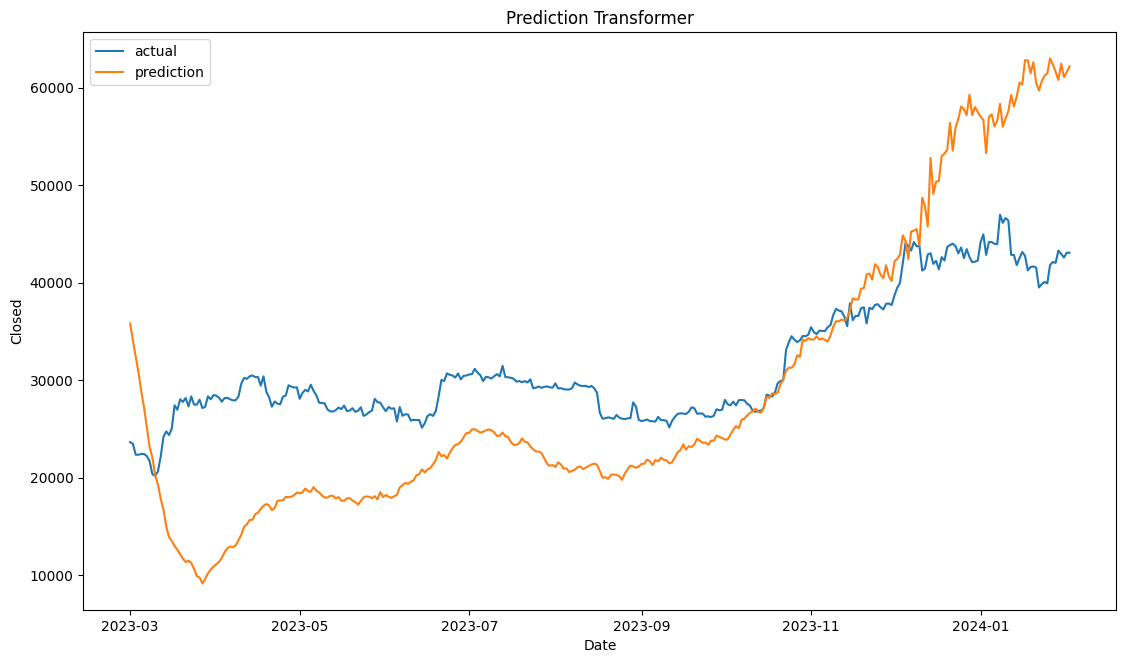

In [20]:
plot(0)

In [18]:
model_class = TransformerModel(model, config, target_column, id_column)
store_model(model_class, "transformer")